# 5.3 Training Error

In the previous sections, we learned to build regression models. In this section, we will learn one way to evaluate the quality of a regression model: the training error. We will also discuss the shortcomings of using training error to measure the quality of a regression model.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.display.max_rows = 5

housing = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/master/data/AmesHousing.txt",
                      sep="\t")
housing

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000
2929,2930,924151050,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,188000


## Performance Metrics for Regression Models

To evaluate the performance of a regression model, we compare the predicted labels from the model against the true labels. Since the labels are quantitative, it makes sense to look at the difference between each predicted label $\hat y_i$ and the true label $y_i$. 

One way to make sense of these differences is to square each difference and average the squared differences. This measure of error is known as **mean squared error** (or **MSE**, for short):

$$ 
\begin{align*}
\textrm{MSE} &= \textrm{mean of } (y_i - \hat y_i)^2.
\end{align*}
$$ 

MSE is difficult to interpret because its units are the square of the units of $y$. To make MSE more interpretable, it is common to take the _square root_ of the MSE to obtain the **root mean squared error** (or RMSE, for short):

$$ 
\begin{align*}
\textrm{RMSE} &= \sqrt{\textrm{MSE}}.
\end{align*}
$$ 

The RMSE measures how off a "typical" prediction is. Notice that the reasoning above is exactly the same reasoning that we used in Chapter 1 when we defined the variance and the standard deviation.

Another common measure of error is the **mean absolute error** (or **MAE**, for short):

$$ 
\begin{align*}
\textrm{MAE} &= \textrm{mean of } |y_i - \hat y_i|.
\end{align*}
$$ 

Like the RMSE, the MAE measures how off a "typical" prediction is. There are other metrics that can be used to measure the quality of a regression model, but these are the most common ones.

## Training Error

To calculate the MSE, RMSE, or MAE, we need data where the true labels are known. Where do we find such data? One natural source of labeled data is the training data, since we needed the true labels to be able to train a model.

For a $k$-nearest neighbors model, the training data is the data from which the $k$-nearest neighbors are selected. So to calculate the training RMSE, we do the following:

For each observation in the training data:
1. Find its $k$-nearest neighbors in the training data.
2. Average the labels of the $k$-nearest neighbors to obtain the predicted label.
3. Subtract the predicted label from the true label.

At this point, we can average the square of these differences to obtain the MSE or average their absolute values to obtain the MAE.

Let's calculate the training MSE for a 10-nearest neighbors model for house price using a subset of features from the Ames housing data set. First, we extract the variables that we need.

In [3]:
# Features in our model. All quantitative, except Neighborhood.
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built", "Yr Sold",
            "Neighborhood"]

X_train_dict = housing[features].to_dict(orient="records")
y_train = housing["SalePrice"]

Now we will use Scikit-Learn to preprocess the features...

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

vec = DictVectorizer(sparse=False)
vec.fit(X_train_dict)
X_train = vec.transform(X_train_dict)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)

...and to fit the $k$-nearest neighbors model to the data.

In [5]:
from sklearn.neighbors import KNeighborsRegressor

# Fit a 10-nearest neighbors model.
model = KNeighborsRegressor(n_neighbors=10)
model.fit(X_train_sc, y_train)

# Calculate the model predictions on the training data.
y_train_pred = model.predict(X_train_sc)
y_train_pred

array([ 164090. ,  131512.5,  154860. , ...,  128530. ,  140600. ,  201800. ])

Now it's time to compare these predictions to the true labels, which we know, since this is the training data.

In [6]:
# Calculate the mean-squared error.
mse = ((y_train - y_train_pred) ** 2).mean()
mse

1139920438.2806828

This number is very large and not very interpretable (because it is in units of "dollars squared"). Let's take the square root to obtain the RMSE.

In [7]:
rmse = np.sqrt(mse)
rmse

33762.707804331731

The RMSE says that our model's predictions are, on average, off by about \\$33,000. This is not great, but it is also not too bad when an average house is worth about \\$180,000.

## The Problem with Training Error

Training error is not a great measure of the quality of a model. To see why, consider a 1-nearest neighbor regression model. Before you read on, can you guess what the training error of a 1-nearest neighbor regression model will be?

In [8]:
# Fit a 1-nearest neighbors model.
model = KNeighborsRegressor(n_neighbors=1)
model.fit(X_train_sc, y_train)

# Calculate the model predictions on the training data.
y_train_pred = model.predict(X_train_sc)

# Calculate the MAE
(y_train - y_train_pred).abs().mean()

57.846416382252556

The training error of this model seems too good to be true. Can our model really be off by just \$57.85 on average?

The error is so small because the nearest neighbor to any observation in the training data will be the observation itself! In fact, if we look at the vector of differences between the true and predicted labels, we see that most of the differences are zero.

In [9]:
y_train - y_train_pred

0       0.0
1       0.0
       ... 
2928    0.0
2929    0.0
Name: SalePrice, Length: 2930, dtype: float64

Why isn't the MSE exactly equal to 0, then? That is because there may be multiple houses in the training data with the exact same values for all of the features, so there may be multiple observations that are a distance of 0.0 away. Any one of these observations has equal claim to being the "1-nearest neighbor". If we happen to select one of the _other_ houses in the training data as the nearest neighbor, then its price will in general be different.

How many predictions did the 1-nearest neighbor model get wrong?

In [10]:
(y_train != y_train_pred).sum()

22

The 1-nearest neighbor model nailed the price exactly for all but 22 of the 2930 houses, so the training error is small.

Of course, a 1-nearest neighbor is unlikely to be the best model for predicting house prices. If one house in the training data happened to cost \\$10,000,000, it would not be sensible to predict another house to cost \\$10,000,000 -- even one very similar to it. This is why we usually average over multiple neighbors (i.e., $k$ neighbors) to make predictions.  

In the next section, we will learn a better way to measure the quality of a model than training error.

# Exercises

**Exercise 1.** Using the Tips data set (`https://raw.githubusercontent.com/dlsun/data-science-book/master/data/tips.csv`), train $k$-nearest neighbors regression models to predict the tip for different values of $k$. Calculate the training MAE of each model and make a plot showing this training error as a function of $k$.

In [57]:
tips_df = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/master/data/tips.csv")
tips_df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [58]:
# subset the data to inputs and output 
X_train_dict = tips_df[["total_bill", "sex", "smoker", "day", "time", "size"]].to_dict(orient="records")
Y_train = tips_df["tip"]

In [59]:
# fit the data to the vectorizer object and transform the data
vec = DictVectorizer(sparse=False)
vec.fit(X_train_dict)
X_train = vec.transform(X_train_dict)

In [60]:
# fit the data to the scaler object and transform it
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)

In [61]:
# Fit a 10-nearest neighbors model.
model = KNeighborsRegressor(n_neighbors=10)
model.fit(X_train_sc, Y_train)

# Calculate the model predictions on the training data.
Y_train_pred = model.predict(X_train_sc)
Y_train_pred

array([ 2.752,  2.17 ,  3.214,  3.064,  3.737,  3.784,  2.115,  4.084,
        2.386,  2.386,  2.115,  3.671,  2.436,  3.112,  2.752,  3.064,
        2.752,  2.639,  2.752,  3.022,  3.007,  2.73 ,  2.73 ,  4.983,
        3.007,  2.713,  2.05 ,  2.05 ,  3.007,  2.73 ,  2.05 ,  2.713,
        2.73 ,  3.072,  3.007,  3.451,  2.665,  2.825,  2.963,  4.085,
        2.665,  2.661,  2.386,  2.115,  4.089,  2.997,  3.064,  4.089,
        4.037,  2.747,  2.302,  2.752,  3.671,  2.115,  4.084,  3.005,
        3.65 ,  2.89 ,  1.957,  5.683,  2.856,  2.121,  1.957,  3.268,
        2.665,  3.04 ,  2.73 ,  2.58 ,  3.007,  2.121,  2.05 ,  2.825,
        3.283,  3.283,  2.73 ,  2.05 ,  2.524,  3.794,  2.999,  2.614,
        3.058,  2.545,  1.701,  3.058,  2.545,  3.553,  2.416,  2.614,
        2.967,  2.999,  3.103,  3.178,  2.653,  2.853,  2.905,  3.291,
        3.103,  2.73 ,  3.103,  2.955,  2.653,  2.653,  4.326,  3.283,
        2.73 ,  2.121,  2.856,  2.941,  3.007,  2.794,  2.282,  2.68 ,
      

In [62]:
tips_mae = np.mean(abs(Y_train_pred - Y_train))
tips_mae

0.74859836065573782

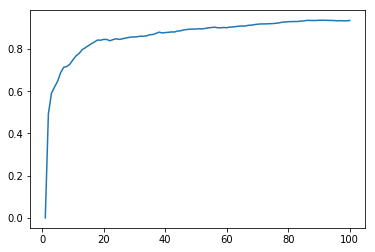

In [67]:
k = pd.Series(range(1, 101))
k.index = range(1, 101)

def mae(k):
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train_sc, Y_train)
    Y_train_pred = model.predict(X_train_sc)
    return np.mean(abs(Y_train_pred - Y_train)) 

k.apply(mae).plot.line()